In [1]:
!pip install matplotlib
!pip install gymnasium==0.28.1
!pip install stable_baselines3==2.1.0
!pip install tqdm

!pip install gym
!pip install stable_baselines
!pip install tensorflow
!pip install shimmy>=0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [2]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from stable_baselines3 import A2C, DQN, PPO

np.set_printoptions(precision=3)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [3]:
class StaticAgent:
    def __init__(self, action):
      self.action = action

    def act(self, state):
        return self.action

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class RandomAgent:
    def __init__(self, risk_level = 0.5):
        self.risk_level = risk_level

    def act(self, state):
      action = random.randint(0, 4)
      if np.random.rand() < self.risk_level:
        action += 5
      return action

In [5]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()


    def reset(self):
        self.change_tyre(self.default_tyre)


    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)


    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00


    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

In [6]:
class Track:
    def __init__(self, opponents, mode = "train"):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.opponents = opponents
        self.mode = mode
        self.cars = [Car() for _ in range(len(self.opponents) + 1)]
        # Target agent's index
        self.target = len(self.opponents)
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()

    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.complexity = [0.00, 0.50, 1.00][np.random.randint(0, 3)]
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstops = [False for i in range(len(self.cars))]
        self.laps_cleared = 0
        self.commited_tyres = np.full_like(self.cars, -1)
        self.time_taken = np.zeros_like(self.cars)
        self.actions = [1 for i in range(len(self.cars))]

        for car in self.cars:
          car.reset()
        return self._get_state()

    def _get_state(self):
      return self._get_states()[self.target]

    def _get_states(self):
      qualified = list(filter(lambda x: x is not None, self.time_taken))

      return [
          [
              self.cars[i].tyre,
              self.cars[i].condition,
              self.wetness[self.cur_weather],
              self.radius,
              self.laps_cleared,
              self.complexity,
              None if self.time_taken[i] is None else len(list(filter(lambda x : x < self.time_taken[i], qualified))),
              None if self.time_taken[i] is None else len(list(filter(lambda x : x > self.time_taken[i], qualified))),
          ] for i in range(len(self.cars))]

    def __calculate_reward(self):
      # Disqualified
      if self.time_taken[self.target] is None:
        return 0

      if self.laps_cleared < self.total_laps:
        lap_reward = 1 if self.mode == "train" else 0
        return lap_reward * 0.125
      else:
        qualified = list(filter(lambda x: x is not None, self.time_taken))
        front = len(list(filter(lambda x : x < self.time_taken[self.target], qualified)))
        reward = [1000, 500, 400, 80][min([3, front])]

        if self.mode == "train":
          i = 3
          while front > i:
            reward *= 0.95
            i += 1

        return reward

    def transition(self, action):
        """
        Args:
            action (int):
                0. [Conservative] Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. [Conservative] Make a pitstop and fit new ‘Soft’ tyres
                2. [Conservative] Make a pitstop and fit new ‘Intermediate’ tyres
                3. [Conservative] Make a pitstop and fit new ‘Fullwet’ tyres
                4. [Conservative] Continue the next lap without changing tyres
                5. [Reckless] Make a pitstop and fit new ‘Ultrasoft’ tyres
                6. [Reckless] Make a pitstop and fit new ‘Soft’ tyres
                7. [Reckless] Make a pitstop and fit new ‘Intermediate’ tyres
                8. [Reckless] Make a pitstop and fit new ‘Fullwet’ tyres
                9. [Reckless] Continue the next lap without changing tyres
        """
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )

        states = self._get_states()
        disqualifications = [False for _ in range(len(self.actions))]

        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
          for i in range(len(self.actions)):
            # Disqualification happens after committing to a strategy for 1 lap
            last_action = self.actions[i]
            accident_rate = 0
            if last_action > 4:
              # Min 1.5%, max 3%
              accident_rate += 0.015 * (1 + self.complexity)
              disqualifications[i] = np.random.rand() < accident_rate

          # Update actions
          for i in range(len(self.opponents)):
            self.actions[i] = self.opponents[i].act(states[i])
          self.actions[-1] = action

        target_velocity = None
        target_reward = None

        ## Pitstop time will be added on the first eight of the subsequent lap
        for i in range(len(self.actions)):
          if self.time_taken[i] is None:
            continue

          time_taken = 0
          action = self.actions[i]
          car = self.cars[i]
          pitstop = self.pitstops[i]
          committed_tyre = self.commited_tyres[i]
          disqualified = disqualifications[i]

          if self.laps_cleared == int(self.laps_cleared):
            if pitstop:
                car.change_tyre(committed_tyre)
                time_taken += car.pitstop_time
                self.pitstops[i] = False

          ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
          if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action % 5 < 4:
              self.pitstops[i] = True
              self.commited_tyres[i] = car.possible_tyres[action % 5]
            else:
              self.pitstops[i] = False

          # we assume that degration happens only after a car has travelled the one-eighth lap
          velocity = car.get_velocity()
          if action > 4:
            velocity *= 1.1
          time_taken += (2 * np.pi * self.radius / 8) / velocity
          reward = 0 - time_taken

          car.degrade(
              w = self.wetness[self.cur_weather], r=self.radius
          )

          if disqualified:
            self.time_taken[i] = None
          else:
            self.time_taken[i] += time_taken
            # self.time_taken[i] += Decimal(time_taken)

          if i == self.target:
            target_velocity = -1 if disqualified else velocity

        self.laps_cleared += 0.125

        if self.laps_cleared == self.total_laps or disqualified:
          self.is_done = True

        next_state = self._get_state()
        return self.__calculate_reward(), next_state, self.is_done, target_velocity

In [7]:
env = Track([RandomAgent()])

agent = StaticAgent(5)

In [8]:
state = env.reset()
print(state)
done = False
G = 0
while not done:
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
print(state)
print("G: ", G)

['Intermediate', 1.0, 0.4, 740, 0, 1.0, 0, 0]
['Ultrasoft', 0.8708852397533469, 0.0, 740, 25.875, 1.0, None, None]
G:  25.75


## Library Testing

Other algos to try:     
https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

In [9]:
from google.colab import drive

drive.mount("/content/drive")
%cd drive/My Drive/Colab Notebooks/Task 2 - Final
%ls

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Task 2 - Final
base_model/  dqn.ipynb         split_models/       stack_models/
dqn/         evaluation.ipynb  split_models.ipynb  stack_models.ipynb


In [10]:
class Sb3Agent:
  def __init__(self, name):
    pass

  def _transform_state(self, tyre, condition, wetness, radius, laps_cleared, complexity, front, back):
    return float(Car().possible_tyres.index(tyre)), condition, wetness, radius, laps_cleared, complexity, front, back

In [11]:
class ProbabilityBasedAgent(Sb3Agent):
  def __init__(self, model, risk_level=0):
    self.model = model
    self.risk_level = risk_level

  def act(self, state):
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = state
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back)
    if front is None or back is None: # Disqualifeid
      return 4
    else:
      action, _ = self.model.predict(np.array([tyre, condition, wetness, radius, laps_cleared]))
      action = int(action)

      if np.random.rand() < self.risk_level:
        action += 5

      return action

In [12]:
class RuleBasedAgent(Sb3Agent):
  def __init__(self, model, min, max):
    self.model = model
    self.min = min
    self.max = max

  def act(self, state):
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = state
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back)
    risk_level = self.min
    risk_level += (self.max - self.min) * (1 - complexity)

    if front is None or back is None: # Disqualified
      return 4
    else:
      action, _ = self.model.predict(np.array([tyre, condition, wetness, radius, laps_cleared]))
      action = int(action)

      # Not leading
      if front > 0 and np.random.rand() < risk_level:
        action += 5

      return action

In [13]:
class DQNAgent(Sb3Agent):
  def __init__(self, model):
    self.model = model

  def act(self, state):
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = state
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back)
    if front is None or back is None: # Disqualifeid
      return 4
    action, _ = self.model.predict(np.array([tyre, condition, wetness, radius, laps_cleared, complexity, front, back]))
    return int(action)

In [14]:
class SplitAgent(Sb3Agent):
  def __init__(self, model_0, model_1):
    self.model_0 = model_0
    self.model_1 = model_1

  def act(self, state):
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = state
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back)
    if front is None or back is None: # Disqualifeid
      return 4
    action_0, _ = self.model_0.predict(np.array([tyre, condition, wetness, radius, laps_cleared]))
    action_1, _ = self.model_1.predict(np.array([laps_cleared, complexity, front, back]))

    if int(action_1) == 0:
      return int(action_0)
    else:
      return int(action_0) + 5

In [167]:
class StackAgent(Sb3Agent):
  def __init__(self, model_0, model_1):
    self.model_0 = model_0
    self.model_1 = model_1

  def act(self, state):
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = state
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back)
    if front is None or back is None: # Disqualifeid
      return 4
    action_0, _ = self.model_0.predict(np.array([tyre, condition, wetness, radius, laps_cleared]))
    action_1, _ = self.model_1.predict(np.array([int(action_0), tyre, condition, wetness, radius, laps_cleared, complexity, front, back]))

    return int(action_1)

In [ ]:
base_model = DQN.load("./base_model/best_model.zip", verbose=0)

agents = [
    ProbabilityBasedAgent(base_model, risk_level=0.05),
    DQNAgent(DQN.load("./dqn/dqn_model.zip", verbose=0)),
    SplitAgent(base_model, DQN.load("./split_models/split_models.zip", verbose=0)),
    StackAgent(base_model, DQN.load("./stack_models/stack_models.zip", verbose=0))
]

for agent in agents:
  env = Track([StaticAgent(1)], mode="test")
  done = False
  state = env.reset()
  G = 0

  while not done:
    action = agent.act(state)
    reward, next_state, done, _ = env.transition(action)
    G += reward
    state = deepcopy(next_state)
    states = env._get_states()

  print(G)

## Evaluation

### Driving Strategy

#### Placing

In [39]:
def evaluate_strategy(agent, tyre, condition, wetness, radius, complexity, front, back):
  driving_strategies = []
  for i in range(161):
    laps_cleared = i + 0.75
    state = [tyre, condition, wetness, radius, laps_cleared, complexity, front, back]
    action = agent.act(state)
    driving_strategy = 0 if action < 5 else 1
    driving_strategies.append(driving_strategy)
  return driving_strategies

In [ ]:
agents = [
    DQNAgent(DQN.load("./dqn/dqn_model.zip", verbose=0)),
    SplitAgent(base_model, DQN.load("./split_models/split_models.zip", verbose=0)),
    StackAgent(base_model, DQN.load("./stack_models/stack_models.zip", verbose=0)),
]
states = [
    ["Intermediate", 0.9, 0.0, 900, 0, 0, 9],
    ["Intermediate", 0.9, 0.0, 900, 0, 1, 8],
    ["Intermediate", 0.9, 0.0, 900, 0, 2, 7],
    ["Intermediate", 0.9, 0.0, 900, 0, 3, 6],
    ["Intermediate", 0.9, 0.0, 900, 0, 4, 5]
  ]

for tyre, condition, wetness, radius, complexity, front, back in states:
  driving_strategies = []
  for agent in agents:
    driving_strategies.append(evaluate_strategy(agent, tyre, condition, wetness, radius, complexity, front, back))
  fig, ax = plt.subplots(figsize=(20,5))
  ax.plot(driving_strategies[0], label='DQN', color='blue', alpha=0.8)
  ax.plot(driving_strategies[1], label='Split Models', color='red', alpha=0.8)
  ax.plot(driving_strategies[2], label='Stack Models', color='green', alpha=0.8)
  ax.set_xlabel('Laps Cleared')
  ax.set_ylabel('Driving Strategy')
  ax.set_title(f"Driving Strategy with {front if front > 0 else 'No'} Leading {'Car' if front == 1 else 'Cars'}")
  ax.legend(loc='best', ncols=1)
  plt.show()

#### Track Complexity

In [130]:
def evaluate_strategy(agent, tyre, condition, wetness, radius, complexity, front, back):
  driving_strategies = [0, 0]
  for i in range(161):
    laps_cleared = i + 0.75
    state = [tyre, condition, wetness, radius, laps_cleared, complexity, front, back]
    action = agent.act(state)
    driving_strategy = 0 if action < 5 else 1
    driving_strategies[driving_strategy] += 1
  return driving_strategies

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [155]:
agents = [
    DQNAgent(DQN.load("./dqn/dqn_model.zip", verbose=0)),
    SplitAgent(base_model, DQN.load("./split_models/split_models.zip", verbose=0)),
    StackAgent(base_model, DQN.load("./stack_models/stack_models.zip", verbose=0)),
]
states = [
    ["Intermediate", 0.9, 0.0, 900, 0, 0, 9],
    ["Intermediate", 0.9, 0.0, 900, 0.5, 0, 9],
    ["Intermediate", 0.9, 0.0, 900, 1, 0, 9]
  ]
histories = []
for agent in agents:
  driving_strategies = []
  for tyre, condition, wetness, radius, complexity, front, back in states:
    driving_strategies.append(evaluate_strategy(agent, tyre, condition, wetness, radius, complexity, front, back)[1])
  histories.append(driving_strategies)

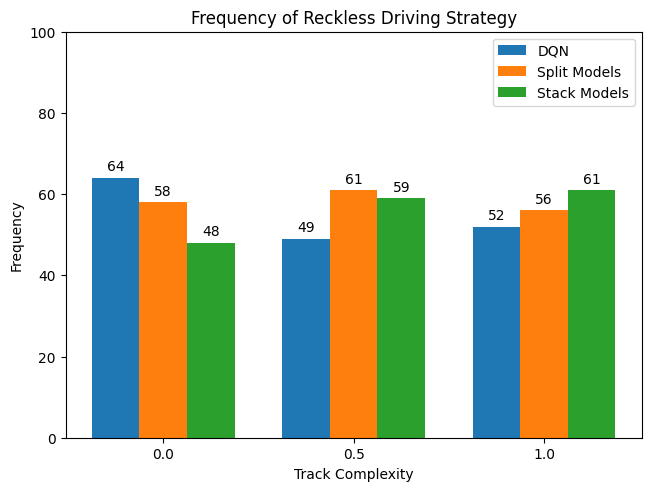

In [156]:
complexities = ("0.0", "0.5", "1.0")
results = {
    'DQN': histories[0],
    'Split Models': histories[1],
    'Stack Models': histories[2],
}

x = np.arange(len(complexities))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for agent, rewards in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, rewards, width, label=agent)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel('Track Complexity')
ax.set_title('Frequency of Reckless Driving Strategy')
ax.set_xticks(x + width, complexities)
ax.legend(loc='upper right', ncols=1)
ax.set_ylim(0, 100)

plt.show()

### Rewards

In [163]:
def run(agent, complexity):
  base_model = DQN.load("./base_model/best_model.zip", verbose=0)
  agents = [
    StaticAgent(1),
    ProbabilityBasedAgent(base_model),
    ProbabilityBasedAgent(base_model, risk_level=0.05),
    ProbabilityBasedAgent(base_model, risk_level=0.1),
    ProbabilityBasedAgent(base_model, risk_level=0.2),
    RandomAgent(risk_level=0),
    RandomAgent(risk_level=0.05),
    RandomAgent(risk_level=0.1),
    RandomAgent(risk_level=0.2)
  ]
  env = Track(agents, mode="test")
  env.reset()
  env.track_complexity = complexity
  state = env._get_state()
  done = False
  G = 0

  while not done:
    action = agent.act(state)
    reward, next_state, done, _ = env.transition(action)
    G += reward
    state = deepcopy(next_state)
  return G

In [164]:
def evaluate(agent, n):
  history = []
  for complexity in [0, 0.5, 1.0]:
    rewards = []
    for _ in range(n):
      reward = run(agent, complexity)
      rewards.append(reward)
    history.append(sum(rewards) / n)
  return history

##### Trained Models

In [165]:
base_model = DQN.load("./base_model/best_model.zip", verbose=0)
histories = []
for agent in [
    DQNAgent(DQN.load("./dqn/dqn_model.zip", verbose=0)),
    SplitAgent(base_model, DQN.load("./split_models/split_models.zip", verbose=0)),
    StackAgent(base_model, DQN.load("./stack_models/stack_models.zip", verbose=0)),
]:
  histories.append(evaluate(agent, 100))

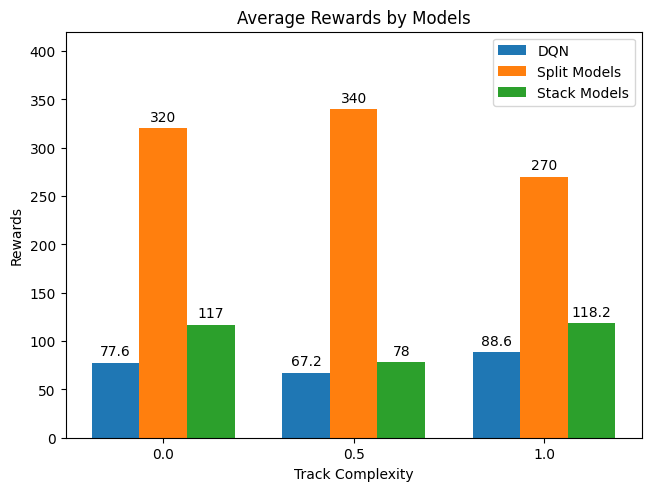

In [166]:
complexities = ("0.0", "0.5", "1.0")
results = {
    'DQN': histories[0],
    'Split Models': histories[1],
    'Stack Models': histories[2],
}

x = np.arange(len(complexities))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for agent, rewards in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, rewards, width, label=agent)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rewards')
ax.set_xlabel('Track Complexity')
ax.set_title('Average Rewards by Models')
ax.set_xticks(x + width, complexities)
ax.legend(loc='upper right', ncols=1)
ax.set_ylim(0, 420)

plt.show()

##### Random Models

In [ ]:
histories = []
for agent in [
    RandomAgent(risk_level=0),
    RandomAgent(risk_level=0.05),
    RandomAgent(risk_level=0.1),
    RandomAgent(risk_level=0.2)
]:
  histories.append(evaluate(agent, 100))

In [ ]:
print(histories)

In [ ]:
complexities = ("0.0", "0.5", "1.0")

results = {
    'r = 0': histories[0],
    'r = 0.05': histories[1],
    'r = 0.1': histories[2],
    'r = 0.2': histories[3]
}

x = np.arange(len(complexities))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for agent, rewards in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, rewards, width, label=agent)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rewards')
ax.set_xlabel('Track Complexity')
ax.set_title('Average Rewards by Risk Level')
ax.set_xticks(x + 0.25, complexities)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 150)

plt.show()

##### Probabilistic Models

In [111]:
base_model = DQN.load("./base_model/best_model.zip", verbose=0)
histories = []
for agent in [
    ProbabilityBasedAgent(base_model, risk_level=0),
    ProbabilityBasedAgent(base_model, risk_level=0.05),
    ProbabilityBasedAgent(base_model, risk_level=0.1),
    ProbabilityBasedAgent(base_model, risk_level=0.2)
]:
  histories.append(evaluate(agent, 100))

In [112]:
print(histories)

[[267.4, 245.2, 283.2], [340.6, 337.8, 391.0], [319.8, 436.8, 445.6], [463.0, 349.0, 316.0]]


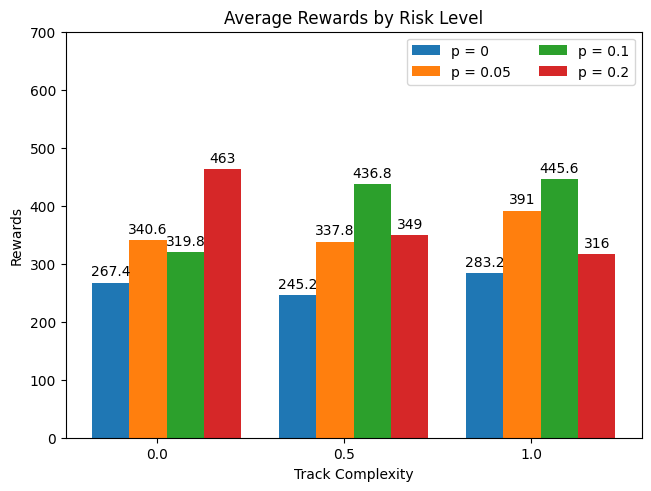

In [114]:
complexities = ("0.0", "0.5", "1.0")

results = {
    'p = 0': histories[0],
    'p = 0.05': histories[1],
    'p = 0.1': histories[2],
    'p = 0.2': histories[3]
}

x = np.arange(len(complexities))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for agent, rewards in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, rewards, width, label=agent)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rewards')
ax.set_xlabel('Track Complexity')
ax.set_title('Average Rewards by Risk Level')
ax.set_xticks(x + 0.25, complexities)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 700)

plt.show()

##### Rule-based Agent

In [115]:
class RuleBasedAgent(Sb3Agent):
  def __init__(self, model, min, max):
    self.model = model
    self.min = min
    self.max = max

  def act(self, state):
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = state
    tyre, condition, wetness, radius, laps_cleared, complexity, front, back = self._transform_state(tyre, condition, wetness, radius, laps_cleared, complexity, front, back)
    risk_level = self.min
    risk_level += (self.max - self.min) * (1 - complexity)

    if front is None or back is None: # Disqualified
      return 4
    else:
      action, _ = self.model.predict(np.array([tyre, condition, wetness, radius, laps_cleared]))
      action = int(action)

      # Not leading
      if front > 0 and np.random.rand() < risk_level:
        action += 5

      return action

In [121]:
base_model = DQN.load("./base_model/best_model.zip", verbose=0)
histories = []
for agent in [
    RuleBasedAgent(base_model, 0.1, 0.4)
]:
  histories.append(evaluate(agent, 100))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


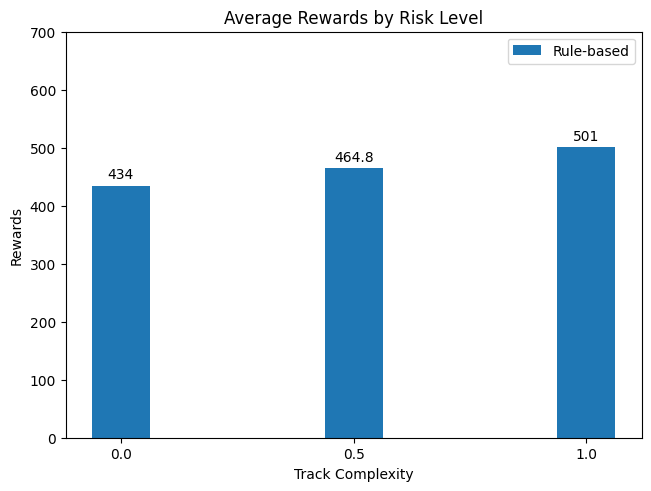

In [122]:
complexities = ("0.0", "0.5", "1.0")

results = {
    'Rule-based': histories[0],
}

x = np.arange(len(complexities))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for agent, rewards in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, rewards, width, label=agent)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rewards')
ax.set_xlabel('Track Complexity')
ax.set_title('Average Rewards by Risk Level')
ax.set_xticks(x, complexities)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 600)

plt.show()